In [1]:
!jupyter nbconvert --to script pack_existing_segs.ipynb

[NbConvertApp] Converting notebook pack_existing_segs.ipynb to script
[NbConvertApp] Writing 1722 bytes to pack_existing_segs.py


In [2]:
from pack_existing_segs import *
from tianshou.utils import WandbLogger
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import logging
import pickle
from enum import Enum
from IPython import display
from pack_existing_segs import unpack_new_seg_out
import utils as ut
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F
import gymnasium as gym
from gymnasium import spaces
import gc
from torchvision.models import resnet50
import numpy as np
from torchvision import transforms
import os
import glob
from PIL import Image
import PIL
import json
from pathlib import Path
import tianshou as ts
from gymnasium.wrappers import TimeLimit
import einops
from transformers import ViTImageProcessor, ViTModel
from customs import custom_offpolicy_trainer, CustomDQNPolicy

/home/server/miniconda3/envs/rl39/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/server/miniconda3/envs/rl39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# if username is server use cuda
if os.environ['USER'] == 'server':
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
else:
    device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
# if __name__ == '__main__':
#     torch.multiprocessing.set_start_method('spawn')

## Dataset

In [4]:
class COCODataset(D.Dataset):
    def __init__(self, root, train=True, length=None, indices=None, no_seg=False):
        self.root = Path(root)
        self.no_seg = no_seg

        with open(self.root / 'annotations/captions_train2017.json', 'r') as f:
            images_info = json.load(f)
        self.file_name_to_id = dict()
        for image_info in images_info['images']:
            self.file_name_to_id[image_info['file_name']] = image_info['id']
            self.file_name_to_id[image_info['id']] = image_info['file_name']  # for reverse search

        with open(self.root / 'cap_dict.json', 'r') as f:
            self.captions_dict = json.load(f)

        if train:
            self.image_files = glob.glob(os.path.join(self.root / 'train2017', "*.jpg"))
        else:
            self.image_files = glob.glob(os.path.join(self.root / 'val2017', "*.jpg"))

        assert length is None or indices is None, "Cannot specify both len and indices"
        assert length is not None or indices is not None, "Must specify either len or indices"
        if length is not None:
            self.image_files = random.sample(self.image_files, length)
        else:
            self.image_files = [self.image_files[i] for i in indices]

    def __getitem__(self, index):
        image_file = self.image_files[index]
        image = PIL.Image.open(image_file)
        image = image.convert('RGB')
        file_name = image_file.split('/')[-1]
        # image_tensor = transforms.ToTensor()(image)
        image_tensor = transforms.Compose([
            transforms.Resize((image.height // 2, image.width // 2)),
            transforms.ToTensor()
        ])(image)

        if self.no_seg:
            seg_output = torch.Tensor()
        else:
            with open(self.root / 'train2017seg' / (str(self.file_name_to_id[file_name]) + '.pkl'), 'rb') as f:
                packed_seg_out = pickle.load(f)
            seg_output = unpack_new_seg_out(packed_seg_out)
            seg_output = transforms.Resize(image_tensor.shape[1:])(torch.from_numpy(seg_output).to(device))

        return image_tensor, seg_output, self.file_name_to_id[file_name]

    def __len__(self):
        return len(self.image_files)

## Environment

In [5]:
class Actions(Enum):
    UP = 0
    RIGHT = 1
    DOWN = 2
    LEFT = 3
    # STAY = 4

In [6]:
class History:
    def __init__(self, patch_size, max_row=None, max_col=None):
        self.patch_size = patch_size
        if max_row is None:
            self._min_row, self._min_col, self._max_row, self._max_col = None, None, None, None
            self.pos_mask = None
            self.history = None
        else:
            self._min_row, self._min_col, self._max_row, self._max_col = 0, 0, max_row, max_col
            self.pos_mask = torch.ones(((max_row + 1) * patch_size[0], (max_col + 1) * patch_size[1]))
            self.history = torch.zeros((3, (max_row + 1) * patch_size[0], (max_col + 1) * patch_size[1]))
            # print(self.pos_mask.shape, self.history.shape)

        self.curr_rel_row, self.curr_rel_col = None, None

    def append(self, patch, row, col):
        if self._min_row is None:
            self._min_row, self._min_col, self._max_row, self._max_col = row, col, row, col
            self.history = patch
            self.pos_mask = torch.ones(patch.shape[1:])
        else:
            if row < self._min_row:
                # pad history with zeros on top to account for row difference
                self.history = torch.cat(
                    (torch.zeros(3, self.patch_size[0] * (self._min_row - row), self.history.shape[2]), self.history),
                    dim=1)
                self.pos_mask = torch.cat(
                    (torch.ones(self.patch_size[0] * (self._min_row - row), self.history.shape[2]), self.pos_mask),
                    dim=0)
                self._min_row = row
            if row > self._max_row:
                # pad history with zeros on bottom to account for row difference
                self.history = torch.cat(
                    (self.history, torch.zeros(3, self.patch_size[0] * (row - self._max_row), self.history.shape[2])),
                    dim=1)
                self.pos_mask = torch.cat(
                    (self.pos_mask, torch.ones(self.patch_size[0] * (row - self._max_row), self.history.shape[2])),
                    dim=0)
                self._max_row = row
            if col < self._min_col:
                # pad history with zeros on left to account for col difference
                self.history = torch.cat(
                    (torch.zeros(3, self.history.shape[1], self.patch_size[1] * (self._min_col - col)), self.history),
                    dim=2)
                self.pos_mask = torch.cat(
                    (torch.ones(self.history.shape[1], self.patch_size[1] * (self._min_col - col)), self.pos_mask),
                    dim=1)
                self._min_col = col
            if col > self._max_col:
                # pad history with zeros on right to account for col difference
                self.history = torch.cat(
                    (self.history, torch.zeros(3, self.history.shape[1], self.patch_size[1] * (col - self._max_col))),
                    dim=2)
                self.pos_mask = torch.cat(
                    (self.pos_mask, torch.ones(self.history.shape[1], self.patch_size[1] * (col - self._max_col))),
                    dim=1)
                self._max_col = col
            # add patch to history
            top = self.patch_size[0] * (row - self._min_row)
            bottom = top + self.patch_size[0]
            left = self.patch_size[1] * (col - self._min_col)
            right = left + self.patch_size[1]

            # print(f"{self._min_row=}, {self._min_col=}, {self._max_row=}, {self._max_col=} {top=}, {bottom=}, {left=}, {right=}")
            self.history[:, top:bottom, left:right] = patch
            self.pos_mask[top:bottom, left:right] = 0
        self.curr_rel_col = col - self._min_col
        self.curr_rel_row = row - self._min_row

In [7]:
class Environment(gym.Env):
    metadata = {"render_modes": ["rgb_array"], "render_fps": 4}

    def __init__(self, dataloader, patch_size=(64, 64)):
        self.dataloader = dataloader
        self.iterator = iter(dataloader)
        self.patch_size = patch_size

        self.observation_space = spaces.Dict({
            'center': spaces.Box(low=0, high=255, shape=(3, self.patch_size[0], self.patch_size[1]), dtype=np.uint8),
            'surrounding': spaces.Box(low=0, high=255, shape=(3, self.patch_size[0], self.patch_size[1]),
                                      dtype=np.uint8),
        })
        self.action_space = spaces.Discrete(len(Actions))

        self.axis_image_render = None

        self.reset()

    def reset(self, **kwargs):
        try:
            # Samples the batch
            self.current_image, self.current_seg, self.image_id = next(self.iterator)
        except StopIteration:
            # restart the iterator if the previous iterator is exhausted.
            self.iterator = iter(self.dataloader)
            self.current_image, self.current_seg, self.image_id = next(self.iterator)

        self.image_id = str(self.image_id.item())
        _, _, self.height, self.width = self.current_image.shape
        self.captions = self.dataloader.dataset.captions_dict[self.image_id]
        self.max_row, self.max_col = (self.height - self.patch_size[0]) // self.patch_size[0], (
                self.width - self.patch_size[1]) // self.patch_size[1]
        self.row, self.col = self.max_row // 2, self.max_col // 2

        # self.seen_patches = torch.zeros((self.max_row + 1, self.max_col + 1))
        self.seen_patches = torch.full((self.max_row + 1, self.max_col + 1), -0.5)
        self.seen_masks = torch.zeros(self.current_seg.shape[0]).to(device)
        # self.history = History(self.patch_size)
        self.history = History(self.patch_size, self.max_row, self.max_col)

        return self._get_obs(), {}

    def _get_patch(self):
        start_row, end_row = self.row * self.patch_size[0], (self.row + 1) * self.patch_size[0]
        start_col, end_col = self.col * self.patch_size[1], (self.col + 1) * self.patch_size[1]
        return self.current_image[0, :, start_row: end_row, start_col: end_col]

    def _get_history(self, new_patch):
        self.history.append(new_patch, self.row, self.col)
        return self.history

    def _get_obs(self):
        patch = self._get_patch()
        history = self._get_history(patch)
        return {
            # 'center': patch,
            # 'surrounding': self._get_surrounding(),
            'history': {
                'history': history.history,
                'pos_mask': history.pos_mask,
                'curr_rel_row': history.curr_rel_row,
                'curr_rel_col': history.curr_rel_col,
                'patch_size': history.patch_size,
            }
        }

    def _get_surrounding(self):
        # get surrounding area and pad with zero on the corresponding side that is out of bound
        surrounding = torch.zeros((3, 3 * self.patch_size[0], 3 * self.patch_size[1]))
        target_start_row = self.patch_size[0] if self.row == 0 else 0
        target_end_row = 2 * self.patch_size[0] if self.row == self.max_row else 3 * self.patch_size[0]
        target_start_col = self.patch_size[1] if self.col == 0 else 0
        target_end_col = 2 * self.patch_size[1] if self.col == self.max_col else 3 * self.patch_size[1]
        start_row = max(0, self.row - 1) * self.patch_size[0]
        end_row = min(self.max_row + 1, self.row + 2) * self.patch_size[0]
        start_col = max(0, self.col - 1) * self.patch_size[1]
        end_col = min(self.max_col + 1, self.col + 2) * self.patch_size[1]
        surrounding[:, target_start_row: target_end_row, target_start_col: target_end_col] = self.current_image[0, :,
                                                                                             start_row: end_row,
                                                                                             start_col: end_col]
        # resize surrounding to match the patch size
        surrounding = transforms.Resize(self.patch_size)(surrounding)
        return surrounding

    def _reward_seg(self):
        start_row, end_row = self.row * self.patch_size[0], (self.row + 1) * self.patch_size[0]
        start_col, end_col = self.col * self.patch_size[1], (self.col + 1) * self.patch_size[1]
        patch_seg = self.current_seg[:, start_row: end_row, start_col: end_col]
        patch_seg = patch_seg.sum(dim=(1, 2)) / self.current_seg.sum(dim=(1, 2))
        seen_threshold = 0.7
        seg_reward = (patch_seg > seen_threshold)
        seg_reward = seg_reward * (1 - self.seen_masks)
        self.seen_masks += seg_reward
        seg_reward = seg_reward.sum().item()

        return seg_reward

    def _reward_return(self):
        reward = -self.seen_patches[self.row, self.col]
        self.seen_patches[self.row, self.col] = 1
        return reward

    def step(self, action):
        if Actions(action) == Actions.UP:
            self.row = self.row - 1 if self.row > 0 else self.row
        elif Actions(action) == Actions.RIGHT:
            self.col = self.col + 1 if self.col < self.max_col else self.col
        elif Actions(action) == Actions.DOWN:
            self.row = self.row + 1 if self.row < self.max_row else self.row
        elif Actions(action) == Actions.LEFT:
            self.col = self.col - 1 if self.col > 0 else self.col
        else:
            raise ValueError("Invalid action")

        obs = self._get_obs()
        # reward_seg = self._reward_seg()
        reward_return = self._reward_return()
        # print(f"{reward_seg=}, {reward_return=}")
        reward = reward_return
        done = False
        truncated = False
        info = {}
        return obs, reward, done, truncated, info

    def _get_render_image(self):
        start_row, end_row = self.row * self.patch_size[0], (self.row + 1) * self.patch_size[0]
        start_col, end_col = self.col * self.patch_size[1], (self.col + 1) * self.patch_size[1]
        image = einops.rearrange(self.current_image.squeeze(), 'c h w -> h w c')
        image[start_row: end_row, start_col: end_col] = 0.8 * image[start_row: end_row, start_col: end_col]
        return image

    def render(self):
        if self.axis_image_render is None:
            self.axis_image_render = plt.imshow(self._get_render_image())
        else:
            display.clear_output(wait=True)
            self.axis_image_render.set_data(self._get_render_image())
            display.display(plt.gcf())


In [8]:
class Q_network_surr_transformer(nn.Module):
    def __init__(self, action_count, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.feature_extractor = resnet50(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(self.feature_extractor.children())[:-2])

        transformer_decoder_layer = nn.TransformerDecoderLayer(d_model=2048, nhead=8, batch_first=True)
        self.transformer_decoder = nn.TransformerDecoder(transformer_decoder_layer, num_layers=1)

        state_shape = 2048
        action_shape = action_count
        self.dueling_head = ts.utils.net.common.Net(state_shape, action_shape, hidden_sizes=[1024], dueling_param=(
            {
                "hidden_sizes": [512, 512],
            },
            {
                "hidden_sizes": [512, 512],
            }
        ), device=device)

        self.resize33 = transforms.Resize((3, 3))
        self.resize11 = transforms.Resize((1, 1))

        # freeze the feature extractor
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

    def forward(self, obs, **kwargs):
        sur_patch = torch.tensor(obs['surrounding']).to(device)
        cent_patch = torch.tensor(obs['center']).to(device)

        surr_enc = einops.rearrange(self.resize33(self.feature_extractor(sur_patch)), 'b c h w -> b (h w) c')
        cent_enc = einops.rearrange(self.resize11(self.feature_extractor(cent_patch)), 'b c h w -> b (h w) c')

        transformer_out = self.transformer_decoder(cent_enc, surr_enc).squeeze(1)
        duel_out = self.dueling_head(transformer_out)
        return duel_out

In [9]:
class Q_network(nn.Module):
    def __init__(self, action_count, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.vit = ViTModel.from_pretrained('facebook/dino-vits8', use_mask_token=True,
                                            proxies={'http': '127.0.0.1:10809', 'https': '127.0.0.1:10809'}).to(device)
        self.vit_patch_size = self.vit.config.patch_size

        state_shape = 384
        action_shape = action_count
        self.dueling_head = ts.utils.net.common.Net(state_shape, action_shape, hidden_sizes=[512], dueling_param=(
            {
                "hidden_sizes": [512],
            },
            {
                "hidden_sizes": [512],
            }
        ), device=device)

        for param in self.vit.parameters():
            param.requires_grad = False

    def forward(self, obs, **kwargs):
        history = obs['history']

        bool_masked_pos = history.pos_mask[:, ::self.vit_patch_size, ::self.vit_patch_size].flatten(start_dim=1)

        out = self.vit(history.history.to(device),
                       bool_masked_pos=bool_masked_pos,
                       interpolate_pos_encoding=True)

        patch_h, patch_w = history.patch_size[:, 0] // self.vit_patch_size, history.patch_size[:,
                                                                            1] // self.vit_patch_size  # todo optimize
        w = history.history.shape[3] // self.vit_patch_size
        i, j = history.curr_rel_row * patch_h, history.curr_rel_col * patch_w
        curr_index = i * w + j + (patch_h // 2) * w + (patch_w // 2)
        # print(f"{out.last_hidden_state.shape=} {i=} {j=} {w=} {patch_w=} {patch_h=} {curr_index=} {history.curr_rel_col=} {history.curr_rel_row=} {history.history.shape=}")
        curr_enc = out.last_hidden_state[:, curr_index[0], :]

        duel_out = self.dueling_head(curr_enc)
        # print(f"{history.curr_rel_row=} {history.curr_rel_col=} \n {curr_enc[:, :4]=} \n {duel_out=}")
        return duel_out

In [10]:
def get_train_fn(policy, eps_train):
    def train_fn(epoch, env_step):
        policy.set_eps(eps_train[epoch - 1])
        # unfreeze the vit after 10 epochs
        if epoch == 10:
            for param in policy.model.vit.parameters():
                param.requires_grad = True
    return train_fn

In [11]:
def register_hooks(model):
    hook0 = model.dueling_head.Q.model[-1].register_forward_hook(lambda self, input, output: print(f"Q: {output}"))
    hook1 = model.dueling_head.V.model[-1].register_forward_hook(lambda self, input, output: print(f"V: {output}"))
    hook2 = model.dueling_head.model.model[0].register_forward_hook(lambda self, input, output: print(f"net: {output}"))


In [ ]:
if __name__ == "__main__":
    # os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
    lr, epoch, batch_size = 3e-5, 100, 32
    test_num = 10
    gamma, n_step, target_freq = 0.9, 1, 400
    buffer_size = 1000
    eps_start, eps_end = 0.9, 0.05
    eps_train, eps_test = np.linspace(eps_start, eps_end, epoch), 0.05
    step_per_epoch, step_per_collect = 2000, 100
    dataset = COCODataset(root="../Data/COCO17", train=True, indices=[12], no_seg=True)
    dataloader = D.DataLoader(dataset, batch_size=1, shuffle=True)
    # train_envs = ts.env.SubprocVectorEnv([lambda: TimeLimit(Environment(dataloader), 100) for _ in range(1)])
    train_envs = ts.env.DummyVectorEnv([lambda: TimeLimit(Environment(dataloader, (32, 32)), 20) for _ in range(1)])
    # test_envs = ts.env.SubprocVectorEnv([lambda: TimeLimit(Environment(dataloader), 100) for _ in range(1)])
    action_count = train_envs.get_env_attr('action_space', 0)[0].n
    net = Q_network(action_count).to(device)
    optim = torch.optim.Adam(net.parameters(), lr=lr)
    # policy = ts.policy.DQNPolicy(net, optim, discount_factor=gamma, estimation_step=n_step, target_update_freq=target_freq)
    policy = CustomDQNPolicy(net, optim, discount_factor=gamma, estimation_step=n_step, target_update_freq=target_freq)
    # register_hooks(policy.model)
    replay_buffer = ts.data.VectorReplayBuffer(buffer_size, len(train_envs))
    train_collector = ts.data.Collector(policy, train_envs, replay_buffer, exploration_noise=True)
    # test_collector = ts.data.Collector(policy, test_envs, exploration_noise=True)
    # wandb_logger = WandbLogger(
    #     train_interval=1,
    #     test_interval=1,
    #     update_interval=1,
    #     project="AttentionRL",
    # )
    # wandb_logger.load(SummaryWriter("./logs"))

    result = custom_offpolicy_trainer(
        policy=policy, train_collector=train_collector, test_collector=None, episode_per_test=test_num, max_epoch=epoch,
        step_per_epoch=step_per_epoch, step_per_collect=step_per_collect,
        batch_size=batch_size, update_per_step=1 / step_per_collect * 4,
        train_fn=get_train_fn(policy, eps_train),
        test_fn=lambda epoch, env_step: policy.set_eps(eps_test),
        stop_fn=lambda mean_rewards: mean_rewards >= 0,
        # logger=wandb_logger
    )

In [ ]:
if __name__ == "__main__":
    env = TimeLimit(Environment(dataloader, (32, 32)), 200)
    ut.show_masks_on_image(einops.rearrange(env.current_image, '1 c h w -> h w c'), env.current_seg.cpu().numpy())
    plt.show()

In [16]:
torch.save(policy.state_dict(), 'saved/policy.pt')

KeyboardInterrupt: 

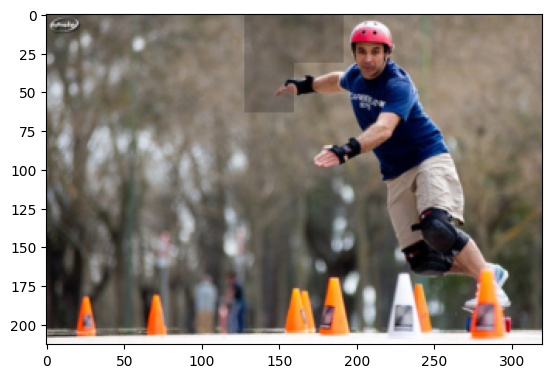

In [19]:
if __name__ == "__main__":
    # dataset = COCODataset(root="../Data/COCO17", train=True, len=1)
    # dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
    policy.eval()
    policy.set_eps(eps_test)
    env = TimeLimit(Environment(dataloader, (32, 32)), 20)
    collector = ts.data.Collector(policy, env, exploration_noise=True)
    collector.collect(n_episode=20, render=1 / 20)